# Project Overview

We are analyzing the University of Texas Women’s Basketball Instagram account to understand what types of posts generate higher engagement.
The project uses image labeling, text analysis, and predictive modeling to study how visuals and captions influence audience interaction and overall engagement on social media.

### **Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import re

import nltk
nltk.download('stopwords')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewwhite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Data Collection**

- We scraped 500+ Instagram posts from the University of Texas Women’s Basketball Instagram account to build our dataset. 
- For each post, we collected the image URL, caption text, and number of likes to use for later analysis of engagement patterns.

### **Image Labeling**

- We used Google Vision API to extract descriptive labels from each image url for the University of Texas Women's Basketball Instagram page. 
- These labels provide a set of keywords that describe what appears in each image. 
- The labels are informative and help us idenfity and classify certain images based on the visual apperance.

#### **Create DataFrame for Modeling**

In [2]:
# Create Df from data
pd.set_option('display.max_colwidth', None)                 # Set_option to display all columns

df = pd.read_excel('cleaned_data_with_image_labels.xlsx')   # Create Df from data
df['caption'].head()                                        # Check out fist few captions

0                                                                                  3,813 likes, 20 comments - texaswbb on August 28, 2025: "built for this ðŸ¤˜  #HookEm". 
1                                                                                 3,833 likes, 14 comments - texaswbb on August 5, 2025: "plan accordingly ðŸ¤˜  #HookEm". 
2                                                                            2,285 likes, 23 comments - texaswbb on June 17, 2025: "year 2 loadingâ€¦ @sec ðŸ¤˜  #HookEm". 
3                                                           2,437 likes, 24 comments - texaswbb on September 30, 2025: "come back any time, @shayholle ðŸ¥¹ðŸ«¶  #HookEm". 
4    483 likes, 3 comments - texaswbb on September 30, 2025: "a big stage for the Burnt Orange - we've got some Texas takeovers headed your way on ABC ðŸ¤˜ðŸ“º  #HookEm". 
Name: caption, dtype: object

#### **Cleaning Text and Captions Begin**

In [3]:
#only grabs what is inside of the quotes as the caption. Removes the number of comments and other text
def extract_quoted_text(text):
    match = re.search(r'"(.*?)"', text)
    if match:
        return match.group(1)
    return ""

df['quoted_caption'] = df['caption'].apply(extract_quoted_text)
display(df[['caption', 'quoted_caption']].head(2))

,caption,quoted_caption
0,"3,813 likes, 20 comments - texaswbb on August 28, 2025: ""built for this ðŸ¤˜ #HookEm"".",built for this ðŸ¤˜ #HookEm
1,"3,833 likes, 14 comments - texaswbb on August 5, 2025: ""plan accordingly ðŸ¤˜ #HookEm"".",plan accordingly ðŸ¤˜ #HookEm


In [4]:
# Add a comment count column
def extract_comment_count(text):
    match = re.search(r'(\d+)\scomments', text)
    if match:
        return int(match.group(1))
    return 0

df['comment_count'] = df['caption'].apply(extract_comment_count)        # Extract comment count

df.head(2)

,post_id,first_image_url,caption,image_labels,likes,binary,quoted_caption,comment_count
0,1,https://scontent-dfw5-2.cdninstagram.com/v/t51.82787-15/540620235_18523400761063615_5393895197861464510_n.jpg?stp=c288.0.864.864a_dst-jpg_e35_s640x640_tt6&_nc_cat=107&ccb=1-7&_nc_sid=18de74&_nc_ohc=1h4hFZFNrKwQ7kNvwGDWgOd&_nc_oc=AdkdWen4wl4RotZoGH2vtIOWyp4gkGkVd908ID26PD2fu9hPqQp1FxZhJWhUg7QkhsU&_nc_zt=23&_nc_ht=scontent-dfw5-2.cdninstagram.com&_nc_gid=GNgABaJZ7KdsF4ZgwuqRgw&oh=00_AfaT-5YRsgJCngz_h-uIDO5lqUhYQUVpxqj_3WIow5RXHw&oe=68E29E9B,"3,813 likes, 20 comments - texaswbb on August 28, 2025: ""built for this ðŸ¤˜ #HookEm"".","Texas Women's Basketball, 2025-26 Schedule, Collegiate Sports, Digital Graphic, Orange and White, Moody Center, NCAA, Team Schedule",3813,1,built for this ðŸ¤˜ #HookEm,20
1,2,https://scontent-dfw5-1.cdninstagram.com/v/t39.30808-6/527467970_1159752589521036_8844723103286263204_n.jpg?stp=c327.0.983.982a_dst-jpg_e35_s640x640_tt6&_nc_cat=101&ccb=1-7&_nc_sid=18de74&_nc_ohc=CwpqqCjiVaMQ7kNvwHZZvIz&_nc_oc=AdmNKEXEWpmu11NBrKAgXjqUxc8p2iX1cT25-pVzVGj6LdFPwlp_relu0xxFpABJuAs&_nc_zt=23&_nc_ht=scontent-dfw5-1.cdninstagram.com&_nc_gid=0O9hGkNz9VRWEfuXQ6PM9g&oh=00_Afbi478KOjvAdccu5yPR0AmUesNkNDuO8VOLsmAICbnJNw&oe=68E2A298,"3,833 likes, 14 comments - texaswbb on August 5, 2025: ""plan accordingly ðŸ¤˜ #HookEm"".","Texas Women's Basketball, 2025-26 season schedule, sports promotional graphic, team logos, game dates, burnt orange and white, basketball player, modern design",3833,1,plan accordingly ðŸ¤˜ #HookEm,14


### **Finding the Median likes to determine thresehold for the Binary Variable**

In [5]:
# Create threshold for binary variable
threshold = df["likes"].median()

# Create binary variable and apply threshold
df["binary"] = (df["likes"] >= threshold).astype(int)
df["binary"].value_counts()


binary
1    275
0    273
Name: count, dtype: int64

#### **EDA for Instagram likes and posts**

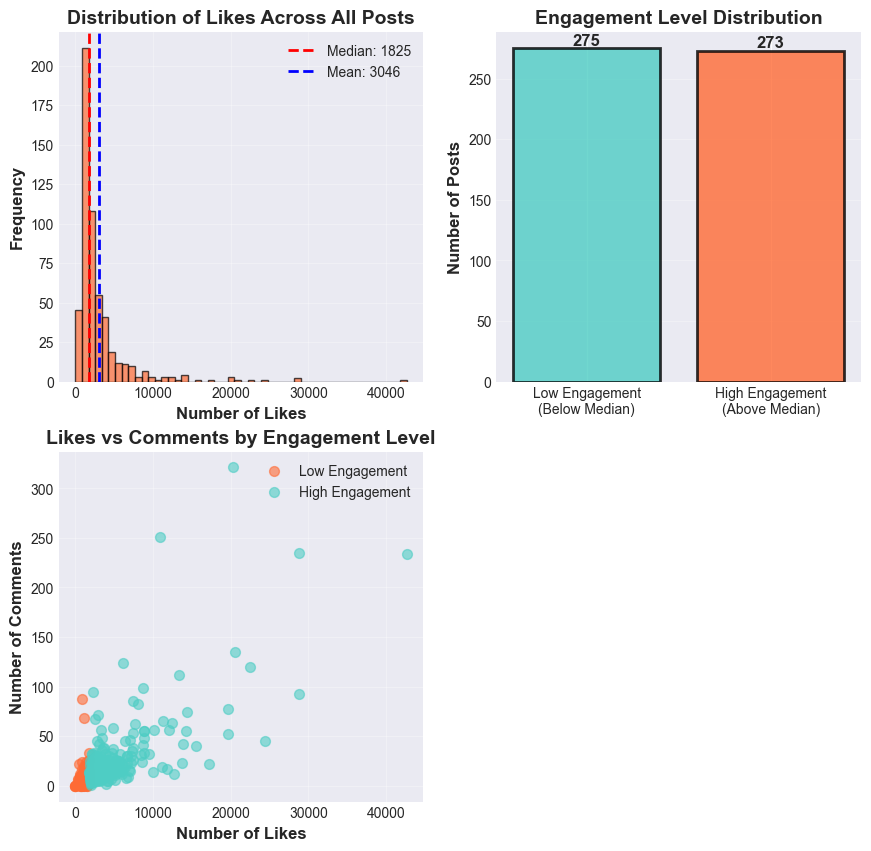

In [6]:
# ============================================================================
# DATA EXPLORATION VISUALIZATIONS
# ============================================================================

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 10))

# Distribution of Likes
ax1 = plt.subplot(2, 3, 1)
plt.hist(df['likes'], bins=50, color='#FF6B35', edgecolor='black', alpha=0.7)
plt.axvline(df['likes'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["likes"].median():.0f}')
plt.axvline(df['likes'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {df["likes"].mean():.0f}')
plt.xlabel('Number of Likes', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Likes Across All Posts', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Binary Engagement Distribution
ax2 = plt.subplot(2, 3, 2)
binary_counts = df['binary'].value_counts()
colors = ['#4ECDC4', '#FF6B35']
bars = plt.bar(['Low Engagement\n(Below Median)', 'High Engagement\n(Above Median)'], 
                binary_counts.values, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
plt.ylabel('Number of Posts', fontsize=12, fontweight='bold')
plt.title('Engagement Level Distribution', fontsize=14, fontweight='bold')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Likes vs Comments Scatter
ax4 = plt.subplot(2, 3, 4)
high_eng = df[df['binary'] == 1]
low_eng = df[df['binary'] == 0]
plt.scatter(low_eng['likes'], low_eng['comment_count'], 
           alpha=0.6, color='#FF6B35', label='Low Engagement', s=50)
plt.scatter(high_eng['likes'], high_eng['comment_count'], 
           alpha=0.6, color='#4ECDC4', label='High Engagement', s=50)
plt.xlabel('Number of Likes', fontsize=12, fontweight='bold')
plt.ylabel('Number of Comments', fontsize=12, fontweight='bold')
plt.title('Likes vs Comments by Engagement Level', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)



## Data Cleaning Step: Fixing Emoji and Special Character Encoding

In the next cell, we begin our data cleaning process by addressing a common issue with social media data: incorrectly encoded emojis or special characters. Instagram captions and machine-generated image labels sometimes contain emojis or accented characters that can appear as garbled text ("mojibake") due to encoding mismatches.




In [7]:
# =========================================================
# Text Preprocessing Pipeline (Clean + Linear)
# =========================================================

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# -------------------------
# Fix encoding issues
# -------------------------
for col in ["caption", "image_labels", "quoted_caption"]:
    df[col] = df[col].astype(str)
    df[col] = df[col].str.encode("cp1252", errors="ignore").str.decode("utf-8", errors="ignore")

# -------------------------
# Clean image labels
# Preserve multi-word phrases
# -------------------------
df["clean_labels"] = df["image_labels"].str.lower()

df["clean_labels"] = df["clean_labels"].str.replace(r"\d+", "", regex=True)
df["clean_labels"] = df["clean_labels"].str.replace(r"[^\w\s\'-]", " ", regex=True)
df["clean_labels"] = df["clean_labels"].str.replace(r"\s+", " ", regex=True)
df["clean_labels"] = df["clean_labels"].str.strip()

# Remove stopwords ONLY for single words
cleaned_labels = []

for text in df["clean_labels"]:
    words = text.split()
    keep_words = []

    for w in words:
        if (" " in w) or (w not in stop_words):
            keep_words.append(w)

    cleaned_labels.append(" ".join(keep_words))

df["clean_labels"] = cleaned_labels

# -------------------------
# Clean captions
# Preserve emojis + hashtags + mentions
# -------------------------
PRESERVE_WORDS = {"longhorns","texaswbb","texas","hookem","moody","sec","ncaa","ncaawbb", "burnt","orange","horns"}

df["clean_caption"] = df["quoted_caption"].str.lower()
df["clean_caption"] = df["clean_caption"].str.replace(r"http\S+|www\S+", "", regex=True)
df["clean_caption"] = df["clean_caption"].str.replace(r"\s+", " ", regex=True)
df["clean_caption"] = df["clean_caption"].str.strip()

cleaned_caps = []

for text in df["clean_caption"]:

    tokens = text.split()
    new_tokens = []

    for t in tokens:

        if (
            t.startswith("#")
            or t.startswith("@")
            or not t.isalpha()
            or t in PRESERVE_WORDS
        ):
            new_tokens.append(t)

        elif t not in stop_words:
            new_tokens.append(lemmatizer.lemmatize(t))

    cleaned_caps.append(" ".join(new_tokens))

df["clean_caption"] = cleaned_caps

# =========================================================
# Quick Preview (Before vs After Cleaning)
# =========================================================



preview_df = df[["quoted_caption", "clean_caption"]].head()
display(preview_df.style.set_properties(subset=["quoted_caption"], **{'width': '40em', "white-space": "pre-wrap"})
                        .set_properties(subset=["clean_caption"], **{'width': '40em', "white-space": "pre-wrap"}))




,quoted_caption,clean_caption
0,built for this 🤘 #HookEm,built 🤘 #hookem
1,plan accordingly 🤘 #HookEm,plan accordingly 🤘 #hookem
2,year 2 loading… @sec 🤘 #HookEm,year 2 loading… @sec 🤘 #hookem
3,"come back any time, @shayholle 🥹🫶 #HookEm","come back time, @shayholle 🥹🫶 #hookem"
4,a big stage for the Burnt Orange - we've got some Texas takeovers headed your way on ABC 🤘📺 #HookEm,big stage burnt orange - we've got texas takeover headed way abc 🤘📺 #hookem


## CountVectorizer - Words to Numbers

In [8]:
# Initialize vectorizer for image labels
vectorizer = CountVectorizer()

# Fit and transform
X = vectorizer.fit_transform(df["clean_labels"].fillna(""))

# Bag-of-words shape (posts × unique terms)
X.shape

# Word frequency table
word_counts = np.asarray(X.sum(axis=0)).ravel()

word_freq = pd.DataFrame({
    "word": vectorizer.get_feature_names_out(),
    "count": word_counts
}).sort_values("count", ascending=False)

# Top image-label terms
word_freq.head(20)


,word,count
90,basketball,484
852,sports,415
72,background,185
906,texas,184
480,indoor,175
42,arena,175
685,player,159
646,orange,158
1008,women,156
7,action,151


#### **Exploring the Hashtag Count and Frequent Hashtags**
- Clearly #hookem leads the list for most frequent hastags 

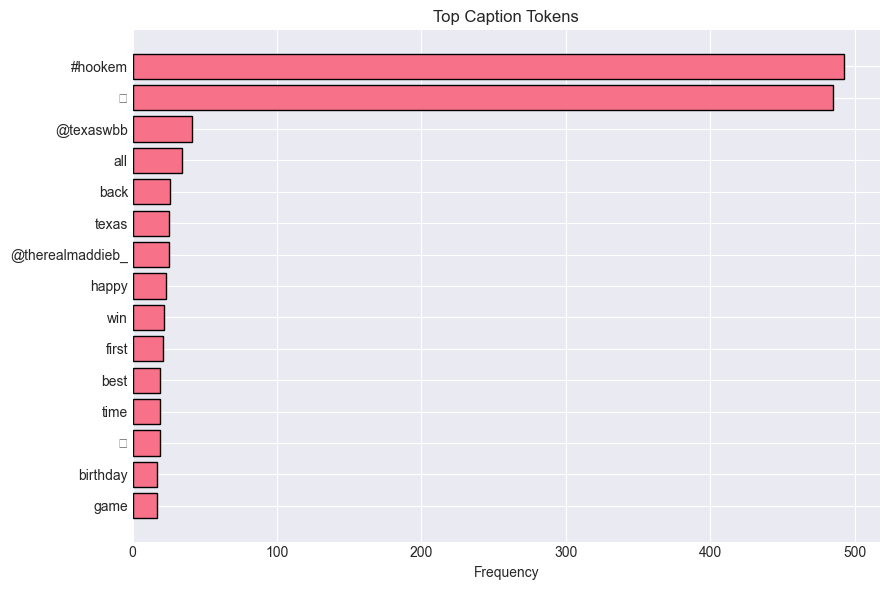

In [9]:
# =====================================================
# Custom tokenizer 
# =====================================================
def custom_tokenizer(text):

    emoji_pattern = (
        r'[\U0001F300-\U0001F9FF]|'
        r'[\U0001F600-\U0001F64F]|'
        r'[\U0001F680-\U0001F6FF]|'
        r'[\u2600-\u26FF]|'
        r'[\u2700-\u27BF]|'
        r'[\U0001FA00-\U0001FAFF]'
    )

    emojis = re.findall(emoji_pattern, text)
    text_no_emoji = re.sub(emoji_pattern, ' ', text)
    words = re.findall(r'\b[a-zA-Z]{2,}\b|#\w+|@\w+', text_no_emoji)

    return words + emojis


# =====================================================
# Vectorize captions
# =====================================================
vectorizer_captions = CountVectorizer(
    tokenizer=custom_tokenizer,
    lowercase=False,
    token_pattern=None
)

X_captions = vectorizer_captions.fit_transform(df["clean_caption"].fillna(""))

# Shape check (clean output)
X_captions.shape


# =====================================================
# Token frequency table
# =====================================================
caption_counts = np.asarray(X_captions.sum(axis=0)).ravel()

caption_freq = pd.DataFrame({
    "token": vectorizer_captions.get_feature_names_out(),
    "count": caption_counts
}).sort_values("count", ascending=False)


# =====================================================
# Core exploration outputs (what actually matters)
# =====================================================

# Top tokens overall
caption_freq.head(20)

# Top hashtags
caption_freq[caption_freq["token"].str.startswith("#")].head(10)

# Top mentions
caption_freq[caption_freq["token"].str.startswith("@")].head(10)

# Top normal words
caption_freq[
    ~caption_freq["token"].str.startswith(("#","@"))
].head(10)


# =====================================================
# Visualization 
# =====================================================
top_tokens = caption_freq.head(15).sort_values("count")

plt.figure(figsize=(9,6))
plt.barh(top_tokens["token"], top_tokens["count"], edgecolor="black")
plt.title("Top Caption Tokens")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



## Train-Test Split Setup

Here I split my Instagram caption data into training and testing sets for the model. I used 70/30 train split. 


In [10]:
# Custom tokenizer for captions (with emojis and hashtags)
def custom_tokenizer(text):
    emoji_pattern = r'[\U0001F300-\U0001F9FF]|[\U0001F600-\U0001F64F]|[\U0001F680-\U0001F6FF]|[\u2600-\u26FF]|[\u2700-\u27BF]|[\U0001FA00-\U0001FAFF]'
    emojis = re.findall(emoji_pattern, text)
    text_no_emoji = re.sub(emoji_pattern, ' ', text)
    words = re.findall(r'\b[a-zA-Z]{2,}\b|#\w+|@\w+', text_no_emoji)
    return words + emojis

# Prepare your data
X = df['binary']  # Target variable (already created in Task C)

# Split into train/test
train_idx, test_idx = train_test_split(df.index, test_size=0.3, random_state=42, stratify=df['binary'])

train_df = df.loc[train_idx]
test_df = df.loc[test_idx]

model_results = {}


### Model 1 - Image Labels Only

In [11]:
vectorizer_labels = CountVectorizer(
    ngram_range=(1, 3),  # Captures 1-3 word phrases
    max_features=500
)

X_train_labels = vectorizer_labels.fit_transform(train_df['clean_labels'])
X_test_labels = vectorizer_labels.transform(test_df['clean_labels'])

# Fit logistic regression
model_labels = LogisticRegression(max_iter=1000, random_state=42)
model_labels.fit(X_train_labels, train_df['binary'])

# Predictions
y_pred_labels = model_labels.predict(X_test_labels)

# Evaluate
model_results['Model 1: Image Labels'] = {
    'accuracy': accuracy_score(test_df['binary'], y_pred_labels),
    'cm': confusion_matrix(test_df['binary'], y_pred_labels),
    'y_pred': y_pred_labels
}

### Model 2 - Captions with Emojis, Hashtags and Mentions

In [12]:
vectorizer_with = CountVectorizer(
    tokenizer=custom_tokenizer,
    lowercase=False,
    token_pattern=None,
    max_features=500
)

X_train_with = vectorizer_with.fit_transform(train_df['clean_caption'])
X_test_with = vectorizer_with.transform(test_df['clean_caption'])

model_with = LogisticRegression(max_iter=1000, random_state=42)
model_with.fit(X_train_with, train_df['binary'])

y_pred_with = model_with.predict(X_test_with)

model_results['Model 2: Captions Only'] = {
    'accuracy': accuracy_score(test_df['binary'], y_pred_with),
    'cm': confusion_matrix(test_df['binary'], y_pred_with),
    'y_pred': y_pred_with
}


### Model 3 - Combined Features (Image Labels + Captions)

In [13]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_labels, X_train_with])
X_test_combined = hstack([X_test_labels, X_test_with])

model_combined = LogisticRegression(max_iter=1000, random_state=42)
model_combined.fit(X_train_combined, train_df['binary'])

y_pred_combined = model_combined.predict(X_test_combined)

model_results['Model 3: Combined'] = {
    'accuracy': accuracy_score(test_df['binary'], y_pred_combined),
    'cm': confusion_matrix(test_df['binary'], y_pred_combined),
    'y_pred': y_pred_combined
}


### Model Comparision

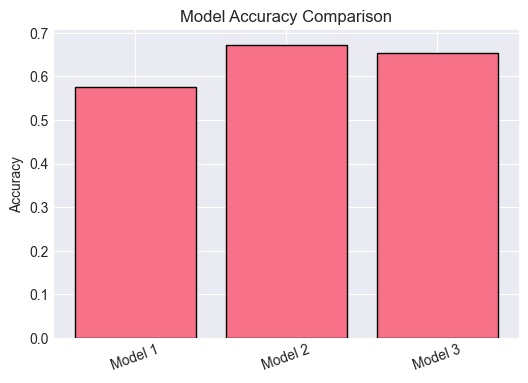

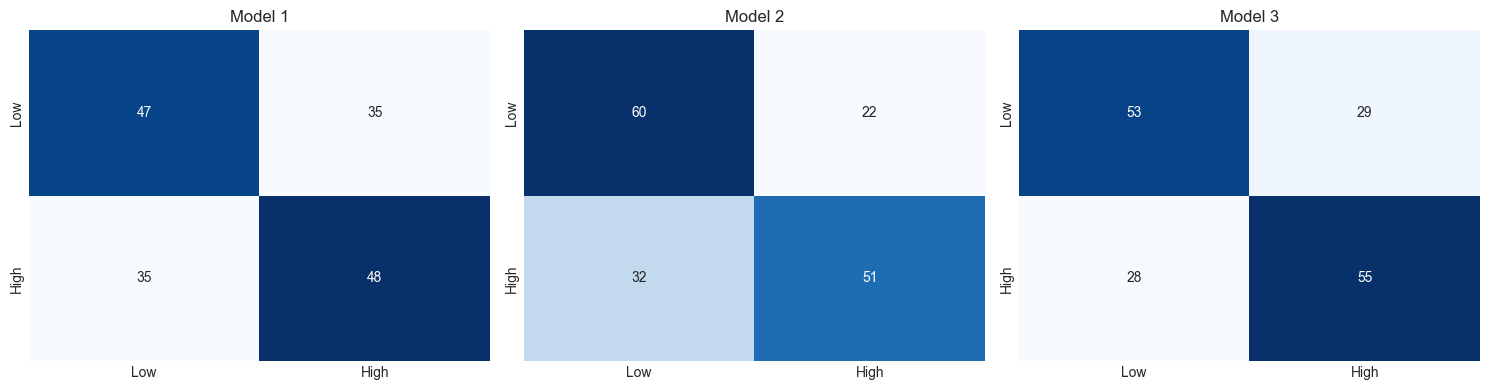

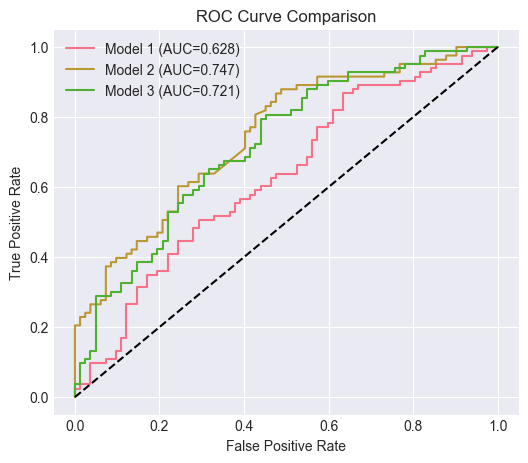

In [14]:
# =====================
# Accuracy Comparison
# =====================
plt.figure(figsize=(6,4))

model_names = list(model_results.keys())
accuracies = [model_results[m]['accuracy'] for m in model_names]

plt.bar(
    [m.split(":")[0] for m in model_names],
    accuracies,
    edgecolor='black'
)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()



# =====================
# Confusion Matrices
# =====================
fig, axes = plt.subplots(1,3, figsize=(15,4))

for ax,(model_name,results) in zip(axes, model_results.items()):

    sns.heatmap(
        results['cm'],
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Low','High'],
        yticklabels=['Low','High'],
        ax=ax
    )

    ax.set_title(model_name.split(":")[0])

plt.tight_layout()
plt.show()



# =====================
# ROC Curves
# =====================

plt.figure(figsize=(6,5))

for model_name in model_results:

    if "Image Labels" in model_name:
        y_proba = model_labels.predict_proba(X_test_labels)[:,1]

    elif "Captions Only" in model_name:
        y_proba = model_with.predict_proba(X_test_with)[:,1]

    else:
        y_proba = model_combined.predict_proba(X_test_combined)[:,1]

    fpr,tpr,_ = roc_curve(test_df['binary'], y_proba)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr,tpr,label=f"{model_name.split(':')[0]} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],'k--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()



In [15]:
TOP_N = 10

# =====================================================
# Helper function to create clean table
# =====================================================
def build_feature_table(features, coefs, prefix=None):

    df_feat = pd.DataFrame({
        "feature": features,
        "coef": coefs
    })

    # Optional prefix (for combined model)
    if prefix is not None:
        df_feat["feature"] = prefix + df_feat["feature"]

    df_feat["coef"] = df_feat["coef"].round(3)

    pos = df_feat.sort_values("coef", ascending=False).head(TOP_N)
    neg = df_feat.sort_values("coef", ascending=True).head(TOP_N)

    return pos, neg


# =====================================================
# MODEL 1 — Image Labels
# =====================================================
feat1 = vectorizer_labels.get_feature_names_out()
coef1 = model_labels.coef_.ravel()

m1_pos, m1_neg = build_feature_table(feat1, coef1)

print("MODEL 1 — Top Positive Signals")
display(m1_pos)

print("MODEL 1 — Top Negative Signals")
display(m1_neg)


# =====================================================
# MODEL 2 — Captions
# =====================================================
feat2 = vectorizer_with.get_feature_names_out()
coef2 = model_with.coef_.ravel()

m2_pos, m2_neg = build_feature_table(feat2, coef2)

print("MODEL 2 — Top Positive Signals")
display(m2_pos)

print("MODEL 2 — Top Negative Signals")
display(m2_neg)


# =====================================================
# MODEL 3 — Combined
# =====================================================
combined_features = np.concatenate([
    np.array(["label__" + f for f in feat1]),
    np.array(["caption__" + f for f in feat2])
])

coef3 = model_combined.coef_.ravel()

m3_pos, m3_neg = build_feature_table(combined_features, coef3)

print("MODEL 3 — Top Positive Signals")
display(m3_pos)

print("MODEL 3 — Top Negative Signals")
display(m3_neg)


MODEL 1 — Top Positive Signals


,feature,coef
29,athlete sports,1.400
376,shooting basketball,1.114
118,college,1.057
471,view,0.960
261,joyful expression,0.916
346,pose,0.914
181,fan,0.900
85,bold typography textured,0.898
39,background,0.826
437,text overlay,0.822


MODEL 1 — Top Negative Signals


,feature,coef
77,blue,-1.347
286,message,-0.995
403,sports announcement,-0.985
385,sky,-0.932
253,interior,-0.920
269,longhorn,-0.903
484,woman golden,-0.860
239,indoor,-0.829
377,shooting motion,-0.824
467,urban,-0.808


MODEL 2 — Top Positive Signals


,feature,coef
204,no,1.180
330,sweet,1.102
144,four,0.929
13,@roriharmon,0.865
199,nation,0.850
15,@shayholle,0.832
474,😤,0.823
485,🤩,0.815
201,new,0.795
406,welcome,0.775


MODEL 2 — Top Negative Signals


,feature,coef
164,home,-1.112
8,@coachvic_ut,-1.032
195,min,-0.979
358,time,-0.784
149,go,-0.769
142,first,-0.760
193,matchup,-0.715
156,half,-0.714
469,🔜,-0.712
29,another,-0.682


MODEL 3 — Top Positive Signals


,feature,coef
29,label__athlete sports,1.037
471,label__view,1.034
704,caption__no,0.931
376,label__shooting basketball,0.894
118,label__college,0.878
39,label__background,0.812
170,label__enthusiastic,0.801
30,label__athletes,0.790
681,caption__longhorn,0.733
867,caption__top,0.723


MODEL 3 — Top Negative Signals


,feature,coef
77,label__blue,-1.117
508,caption__@coachvic_ut,-0.841
664,caption__home,-0.821
239,label__indoor,-0.816
109,label__chair,-0.795
253,label__interior,-0.791
311,label__orange white,-0.791
403,label__sports announcement,-0.771
243,label__indoor court,-0.768
385,label__sky,-0.755


# **Topic Modeling (LDA)**
We applied Latent Dirichlet Allocation (LDA) to the image labels to identify the main visual themes appearing across posts. We compared topic proportions between high- and low-engagement posts to see which themes are more common in top-performing content.

In [16]:
NUM_TOPICS = 3
TOP_N_WORDS = 15

_stop = set(stopwords.words("english"))
_lem = WordNetLemmatizer()

docs = (
    df["clean_labels"]
    .fillna("")
    .str.lower()
    .str.split()
    .apply(lambda toks: [t for t in toks if t not in _stop and len(t) > 2])
    .apply(lambda toks: [_lem.lemmatize(t) for t in toks])
)

docs = docs[docs.map(len) > 0].tolist()

dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(d) for d in docs]

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10
)

topics = lda_model.show_topics(num_topics=NUM_TOPICS, num_words=TOP_N_WORDS, formatted=False)
for topic_id, words in topics:
    print(f"Topic {topic_id+1}: " + ", ".join([w for w, _ in words]))


# -------------------------
# DOCUMENT-TOPIC PROPORTIONS (for merge + plots later)
# -------------------------
# Define topic names mapping, or just use default names if not defined
try:
    TOPIC_NAMES
except NameError:
    TOPIC_NAMES = {i: f"Topic {i+1}" for i in range(NUM_TOPICS)}

doc_rows = []
for doc_id, bow in enumerate(corpus):
    dist = lda_model.get_document_topics(bow, minimum_probability=0)
    row = {"Image_ID": doc_id + 1}
    for t_id, prob in dist:
        # Use the topic name if available; otherwise default to Topic N+1
        topic_col = TOPIC_NAMES.get(t_id, f"Topic {t_id+1}")
        row[topic_col] = prob
    doc_rows.append(row)

df_doc_topics = pd.DataFrame(doc_rows)
display(df_doc_topics.head())


Topic 1: basketball, sport, graphic, texas, longhorn, orange, typography, women's, design, textured, promotional, bold, white, university, player
Topic 2: lighting, background, portrait, woman, dark, sport, golden, smiling, regal, throne, dramatic, event, basketball, ornate, black
Topic 3: basketball, sport, player, indoor, arena, action, background, athlete, smiling, shot, texas, candid, female, game, orange


,Image_ID,Topic 1,Topic 2,Topic 3
0,1,0.807717,0.169058,0.023225
1,2,0.964061,0.017189,0.018749
2,3,0.968799,0.015312,0.015889
3,4,0.025235,0.024699,0.950066
4,5,0.968132,0.015849,0.016019


### **Topic Selection:**

#### **Topic 1: Graphic, Posters and Branding:**

“womens basketball,” “bold typography,” “textured background,” “university of texas,” “sports graphic,” “longhorn logo,” and “sports promotional graphic,”

#### **Topic 2: Off-Court, Behind the Scenes:**

“candid moment,” “indoor arena,” “dark background,” “dramatic lighting,” “braided hair,” “hook em horns gesture,” “candid shot,” and “smiling woman,”

#### **Topic 3: In-Game, Live Action:**

“action shot,” “indoor court,” “basketball player,” “orange jersey,” “indoor sports arena,” “basketball hoop,” and “womens basketball game,”


## **Topic Selection Visuals**

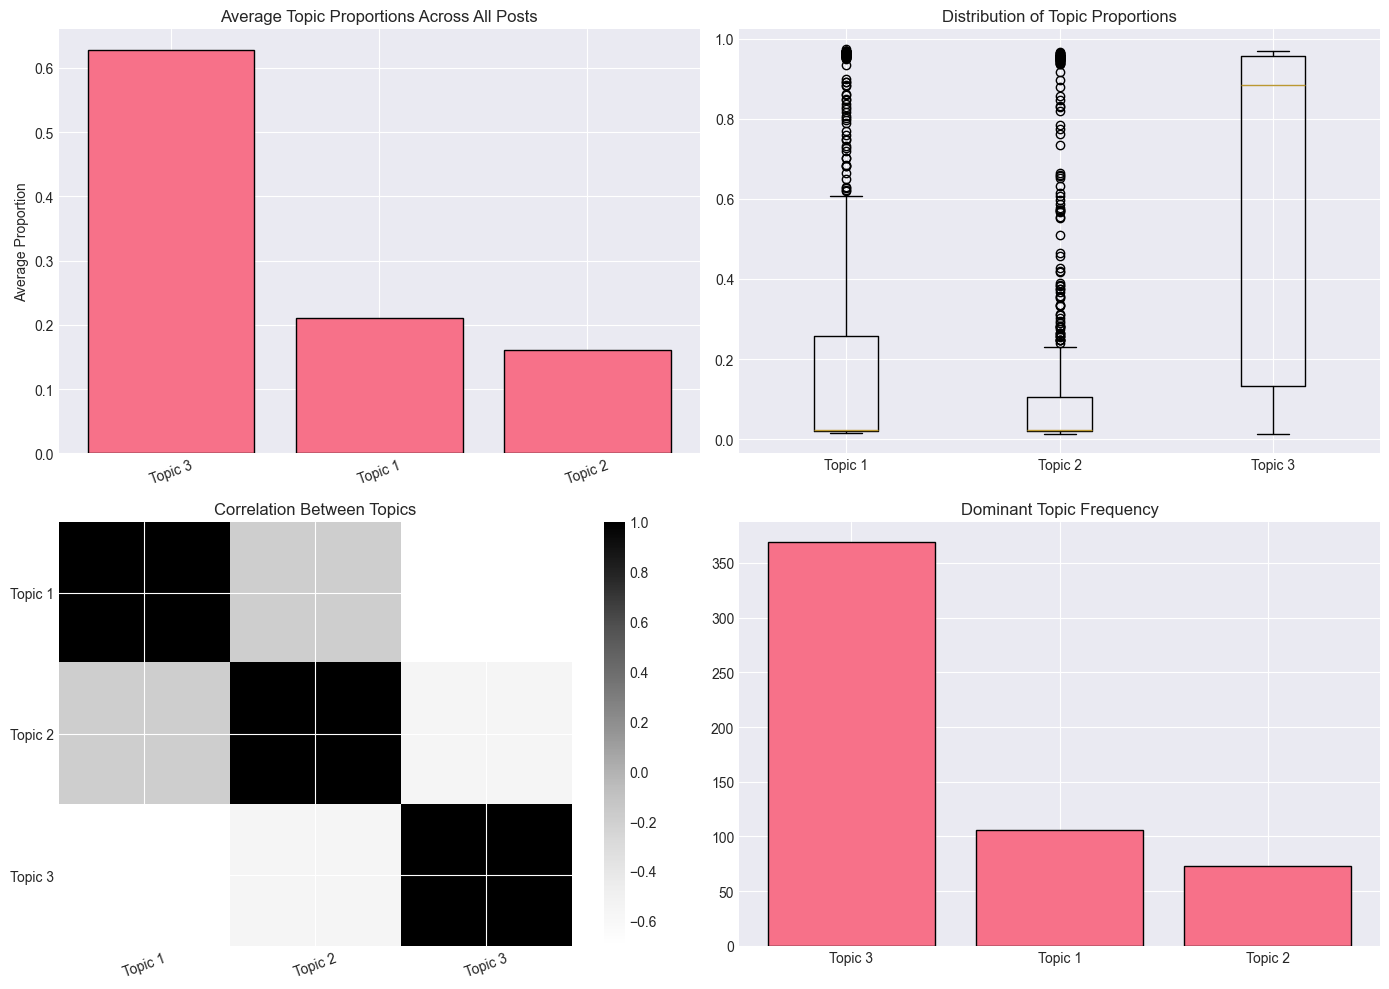

In [17]:
import os

# Create figures folder if needed
if not os.path.exists("figures"):
    os.makedirs("figures")

# Use existing df_doc_topics if available
if "df_doc_topics" in globals():
    df_with_topics = df_doc_topics.copy()
else:
    df_with_topics = pd.read_csv("outputs/image_topic_proportions_3topics.csv")

topic_cols = [c for c in df_with_topics.columns if c != "Image_ID"]

# Average proportions
avg_props = df_with_topics[topic_cols].mean().sort_values(ascending=False)

# Dominant topic
df_with_topics["Dominant_Topic"] = df_with_topics[topic_cols].idxmax(axis=1)
dominant_counts = df_with_topics["Dominant_Topic"].value_counts()

# Correlation
corr = df_with_topics[topic_cols].corr()

# Plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A) Average
ax = axes[0, 0]
bars = ax.bar(avg_props.index, avg_props.values, edgecolor="black")
ax.set_title("Average Topic Proportions Across All Posts")
ax.set_ylabel("Average Proportion")
ax.set_xticklabels(avg_props.index, rotation=20)

# B) Boxplot
ax = axes[0, 1]
ax.boxplot([df_with_topics[c].values for c in topic_cols], labels=topic_cols)
ax.set_title("Distribution of Topic Proportions")

# C) Correlation
ax = axes[1, 0]
im = ax.imshow(corr.values, aspect="auto")
ax.set_title("Correlation Between Topics")
ax.set_xticks(range(len(topic_cols)))
ax.set_yticks(range(len(topic_cols)))
ax.set_xticklabels(topic_cols, rotation=20)
ax.set_yticklabels(topic_cols)
fig.colorbar(im, ax=ax)

# D) Dominant frequency
ax = axes[1, 1]
ax.bar(dominant_counts.index, dominant_counts.values, edgecolor="black")
ax.set_title("Dominant Topic Frequency")

plt.tight_layout()

# SAVE
plt.savefig("figures/lda_topic_visuals.png", dpi=200, bbox_inches="tight")

plt.show()


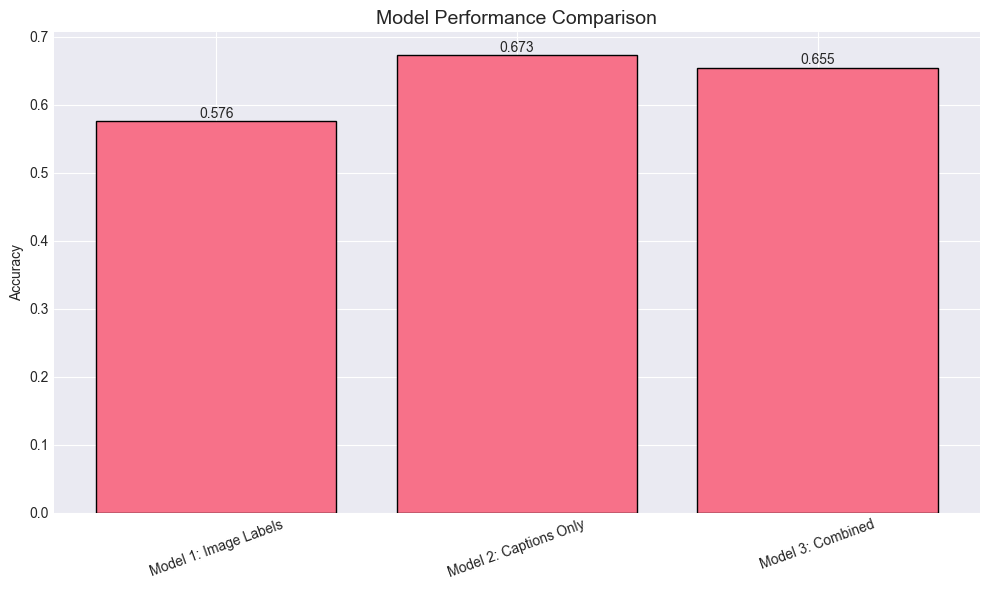

In [19]:
# ===============================
# MODEL COMPARISON PLOT (PORTFOLIO CLEAN)
# ===============================

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Create figures folder if not exists
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# ---------------------
# Accuracy Comparison Plot
# ---------------------

model_names = list(model_results.keys())
accuracies = [model_results[m]['accuracy'] for m in model_names]

plt.figure(figsize=(10,6))

bars = plt.bar(
    model_names,
    accuracies,
    edgecolor="black"
)

plt.title("Model Performance Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks(rotation=20)

# Add labels above bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.005,
        f"{acc:.3f}",
        ha="center",
        fontsize=10
    )

plt.tight_layout()

# SAVE TO FIGURES FOLDER
plt.savefig(FIG_DIR / "model_comparison.png", dpi=200, bbox_inches="tight")

plt.show()
